<a href="https://colab.research.google.com/github/Gautam0507/MAT496-Introduction-to-LLMs/blob/main/Chapter-3/Chapter_3_Coding_Attention_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is there in this notebook

We will be learning about the theory and implementation of 4 different variants of attention mechanisms

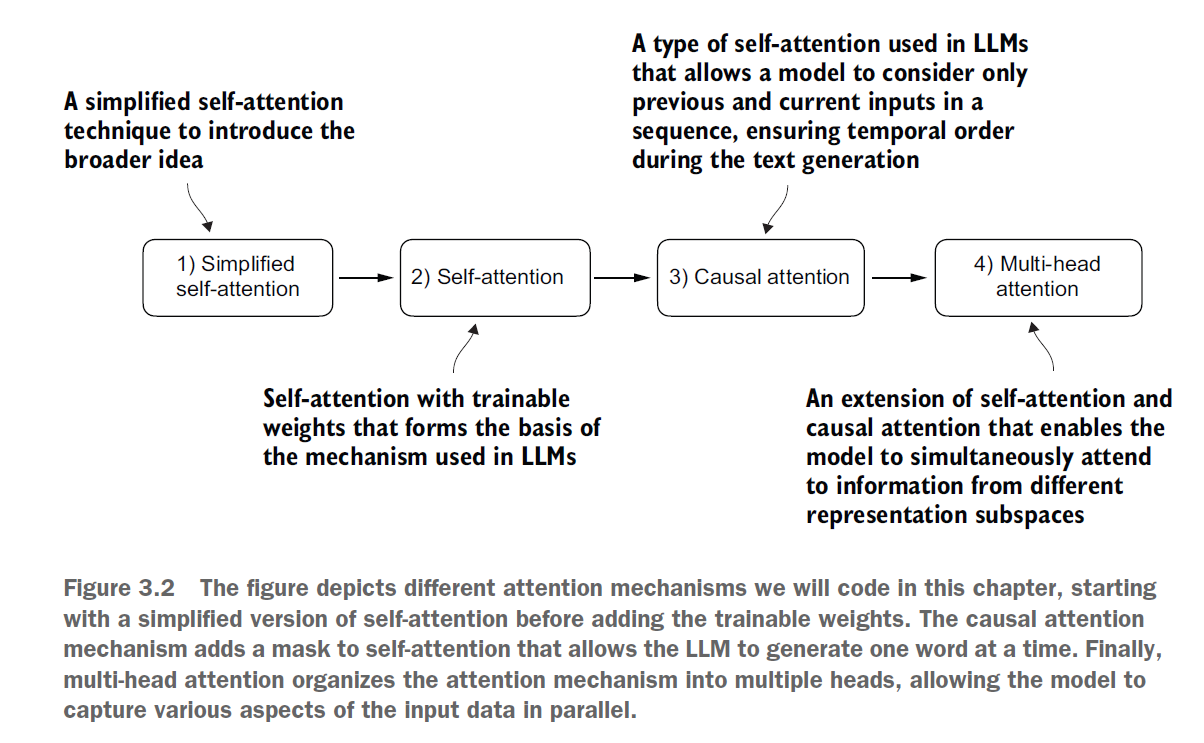

# 3.1 The problem with modeling long sequences

Things like language translation need to process the entire text first and only then translate. Since the grammatical strcuture and sentence sttructure of various languages are different we need to process the entire text to get the context and only then translate

To address this we got an ecoder decoder setup

- **Encoder-Decoder Setup**:  
  - Deep neural networks used for tasks like language translation.
  - **Encoder**: Reads and processes input text.
  - **Decoder**: Generates translated output text.

- **Before Transformers**:  
  - **RNNs (Recurrent Neural Networks)** were popular for encoder-decoder architecture.
  - RNNs process sequential data by feeding previous outputs as inputs to the next step.

- **How Encoder-Decoder RNNs Work**:  
  - **Encoder**:
    - Processes the input text step by step.
    - Updates its hidden state to capture the meaning of the sentence.
  - **Decoder**:
    - Uses the final hidden state to start generating the translated sentence, one word at a time.
    - Updates hidden state at each step to keep track of context for the next word.

- **Key Concept**:  
  - Encoder creates a hidden state (memory cell) representing the entire input.
  - Decoder uses this hidden state (embedding vector) to produce the output.

- **Limitation of Encoder-Decoder RNN**:  
  - RNNs can't directly access earlier hidden states during decoding, leading to possible loss of context.
  - This is problematic for complex sentences where dependencies span long distances.

  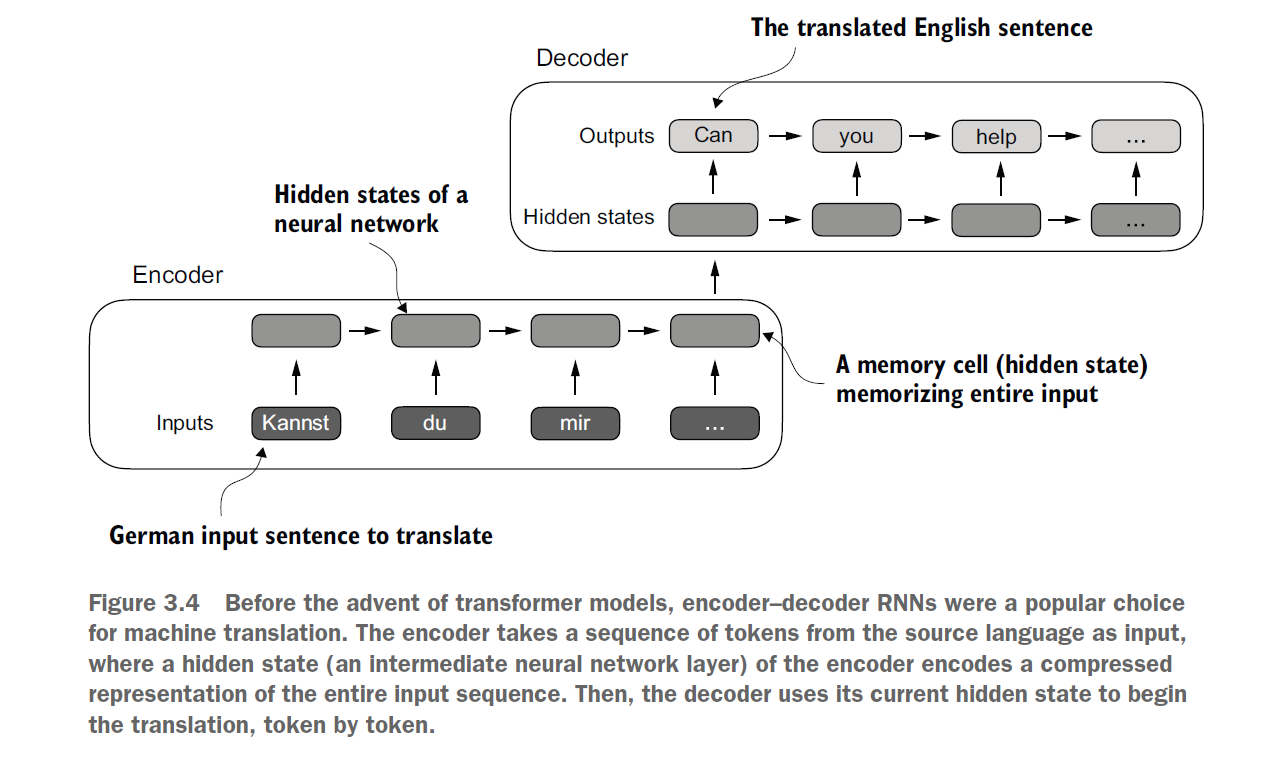

# 3.2 Capturing  data dependencies with attention mechanisms


To address the shortcomings of RNN Encoder Decoder architecture the Bahdanau attention mechanism was introduced.
- **Bahdanau attention** - decoder can selectively access different parts of the input sequence at each decoding step
- **Transformer Architecture** - Introduced the self attention mechanism

**Self Attention** Self-attention is a mechanism that allows each position in the input sequence to consider the relevancy of, or “attend to,” all other positions in the same sequence when computing the representation of a sequence.

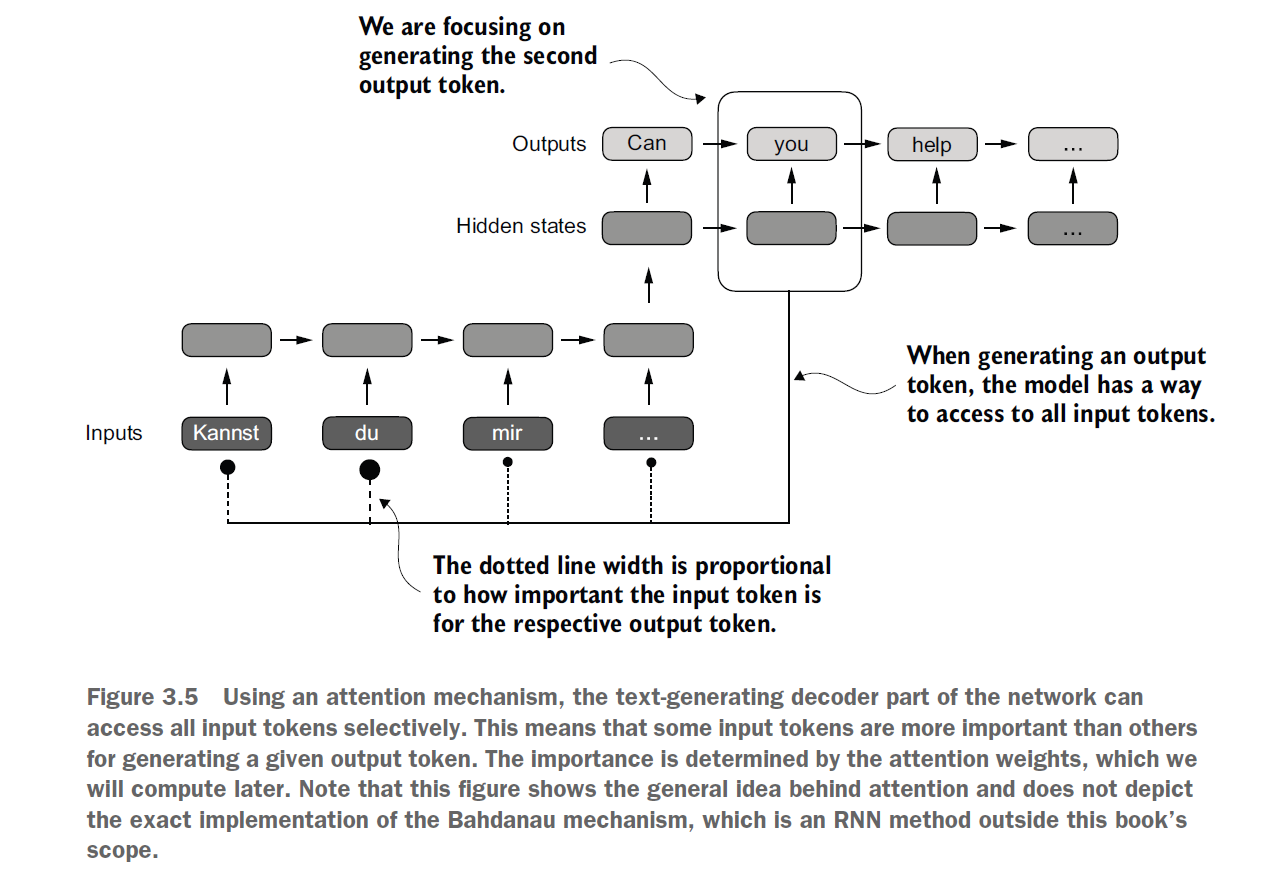

# 3.3 Attending to different parts of the input with self-attention

the “self” refers to the mechanism’s ability to compute attention
weights by relating different positions within a single input sequence. It assesses and learns the relationships and dependencies between various parts of the input itself, such as words in a sentence or pixels in an image.

## 3.3.1 A simple self-attention mechanism without trainable weights

TODO: GO through and label the parts mathematically what is getting calculated

The fugere below illustrates the process of **self-attention** by computing **context vectors** for each input element in a sequence. The input sequence consists of **T elements**, denoted as \( x(1) \) to \( x(T) \), where each element represents a token embedding of words in a sentence.

For example, in the sentence:
> *"Your journey starts with one step."*

Each word (e.g., *"Your"*, *"journey"*) is mapped to a **d-dimensional embedding vector**.

In the code below we are computing the context vector for the word journey in the sentence

### Self-Attention and Context Vectors
- The goal of **self-attention** is to create **context vectors** $ z(i) $ for each input element $ x(i) $.
- These **context vectors** combine information from **all** other input elements, enriching the representation of each token.
- In the figure, the context vector \( z(2) \) (for *"journey"*) is computed using **attention weights** \( \alpha_{21} \) to \( \alpha_{2T} \), which determine how much influence each input element has on \( z(2) \).

### Importance in Large Language Models (LLMs)
- **Context vectors** help LLMs **understand relationships** between words by incorporating relevant information from all tokens in a sentence.
- This enables **better comprehension** of the text and improves **next-token prediction**.
- In later steps, trainable weights will be added to optimize how context vectors are formed.

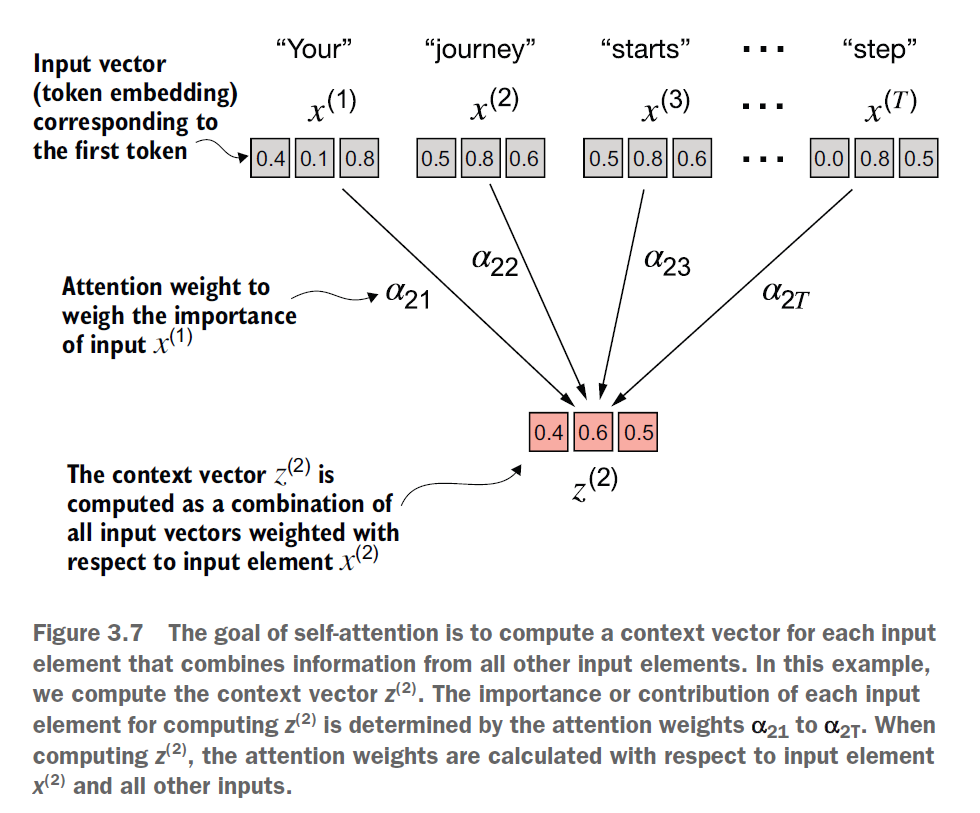

In [ ]:
import torch

In [ ]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89 ], # your
     [0.55, 0.87, 0.66], # journey
     [0.57, 0.85, 0.64], # starts
     [0.22, 0.58, 0.33], # with
     [0.77, 0.25, 0.10], # one
     [0.05, 0.80, 0.55]] # step
)

Calculating Intermediate Attetion Scores between Query token (journey) and each input token

We simply calculate the product of the query token and all other tokens

We use dot product because the dot product is a measure of similarity because it quantifies how closely two vectors are aliged


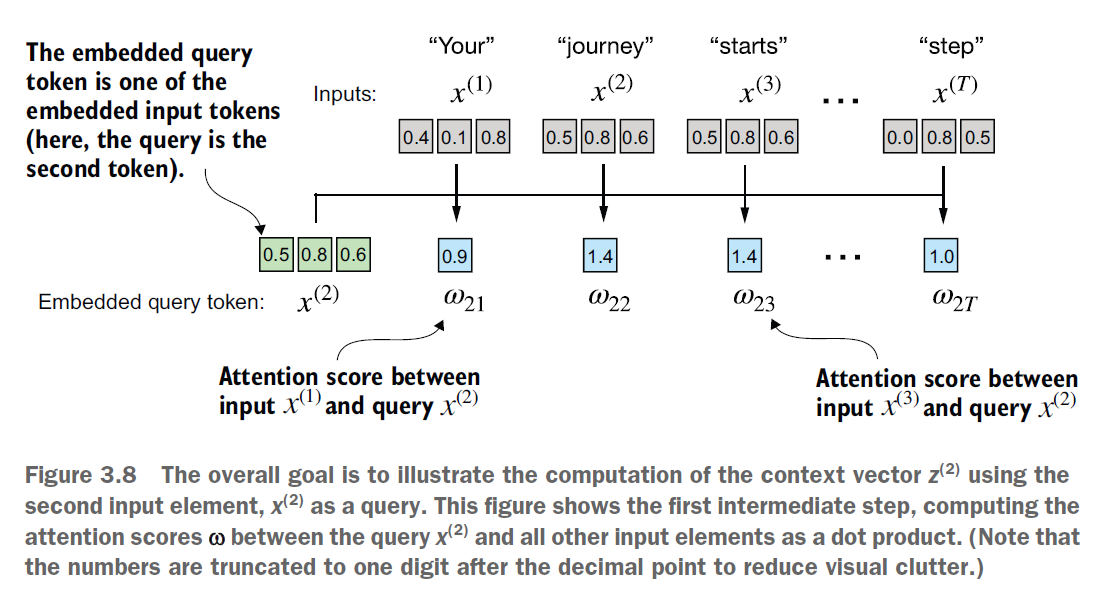

In [ ]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
  attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


Normalizing the above attention scores
- Easier Interpretation
- Maintains LLM training stability

These normalized attention scores are called **attention weights**

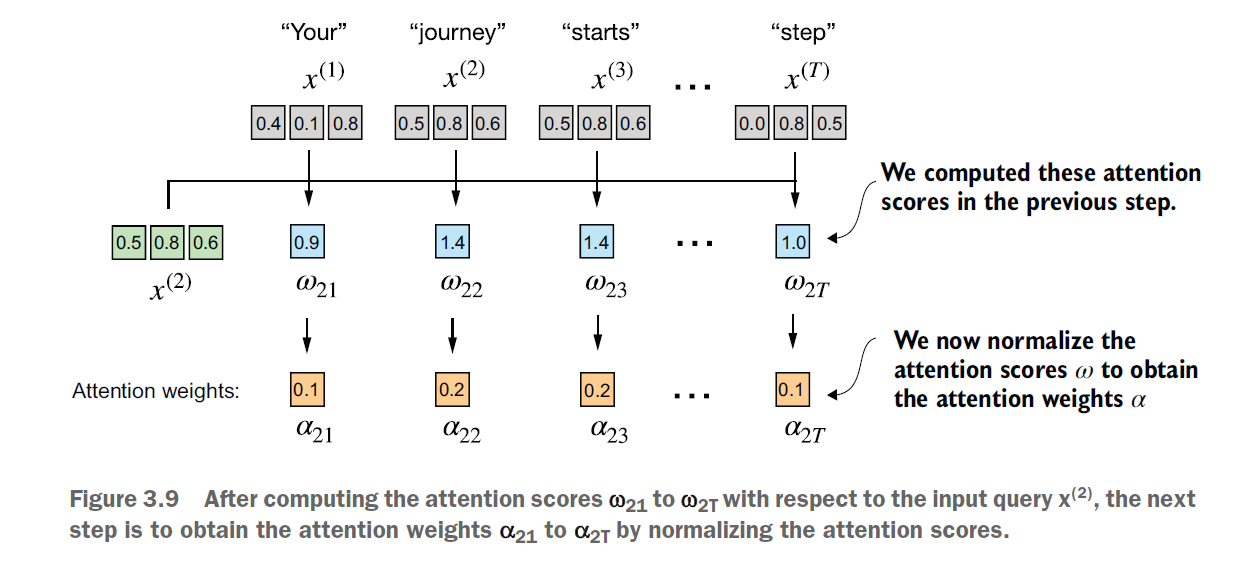

In [ ]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In practice we use the softmax function for normalization instead

In [ ]:
def softmax_naive(x):
  return torch.exp(x) / torch.exp(x).sum(dim=0)

In [ ]:
attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention Weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention Weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


using inbuilt softmax in torch to prevent  optimization and numerical instability problems

In [ ]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention Weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention Weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Calculating the context vector $z^{(2)}$

context vector z(2) is the weighted sum of all input vectors, obtained by multiplying each input vector by its corresponding attention weight:

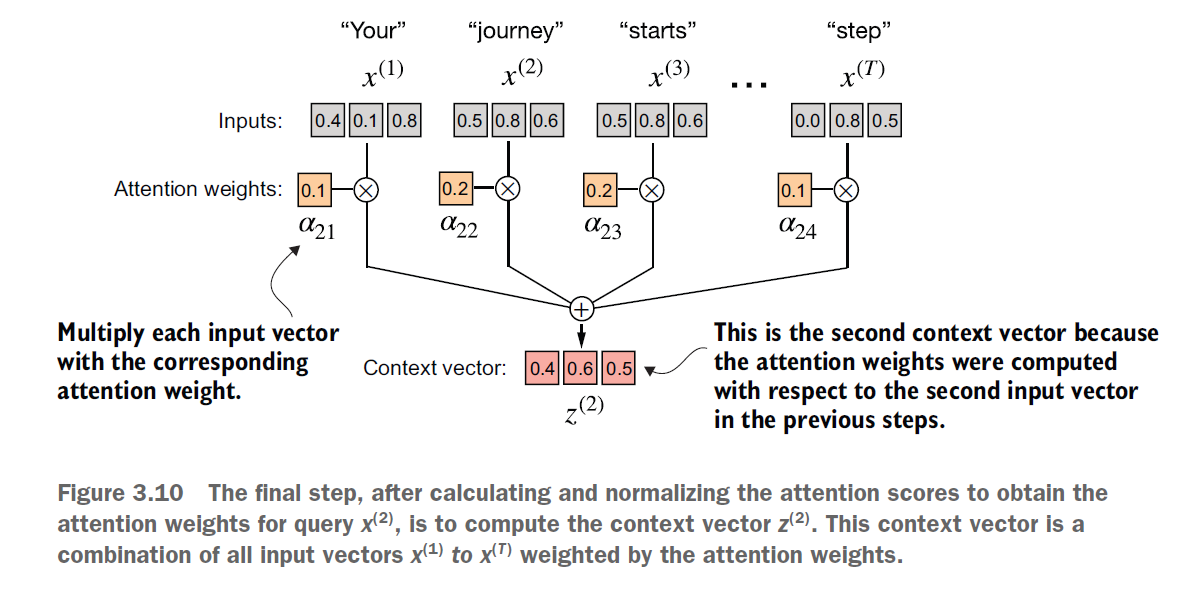

In [ ]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
  context_vec_2 += attn_weights_2[i] * x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


## 3.3.2 Computing attention weights for all input tokens

Extending the above computation to compute the context vectors for all input values

Calculating attention scores

In [ ]:
attn_scores = torch.empty(6,6)
for i, x_i in enumerate(inputs):
  for j, x_j in  enumerate(inputs):
    attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


Attention scores can be done using matrix multiplication efficiently as given below

In [ ]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


Normalizing the attention scores

In [ ]:
attn_weights = torch.softmax(attn_scores, dim = -1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [ ]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Computing context vectors for all inputs

In [ ]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [ ]:
print("Current 2nd context vector:", all_context_vecs[1])
print("Previous 2nd context vector:", context_vec_2)

Current 2nd context vector: tensor([0.4419, 0.6515, 0.5683])
Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


# 3.4 Implementing self-attention with trainable weights

Implementing self attention mechanism.

Self attention is also called the scaled dot-product attention

We introduce weight matrices that are updated during model training.

## 3.4.1 Computing the attention weights step by step

We Introduce 3 trainable weight matrices

These three matrices are used to project the embedded input tokens, x(i), into query, key, and value vectors

weight parameters are the fundamental, learned coefficients that define
the network’s connections, while attention weights are dynamic, context-specific values



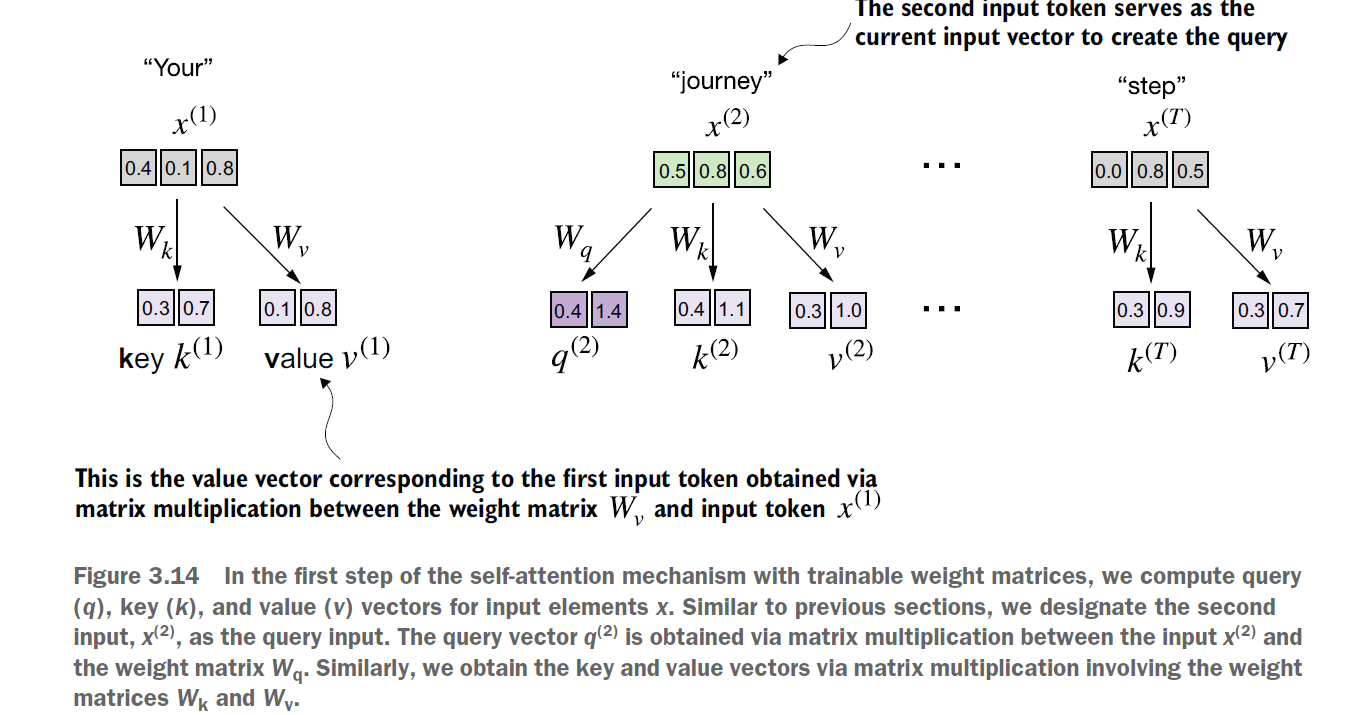

The terms **key, query, and value** in attention mechanisms come from information retrieval and databases.  

- **Query**: Like a search query in a database, it represents the current token the model focuses on and is used to find relevant information in the input sequence.  
- **Key**: Similar to a database key, each token in the input has an associated key used for matching with the query.  
- **Value**: Like a value in a key-value pair, it holds the actual content. Once relevant keys are found, their corresponding values are retrieved to generate the final output.  


Usually in GPT Models input and output embedding size is the same.

Here it is given differently for following and understanding computation

In [ ]:
x_2 = inputs[1]
d_in = inputs.shape[1] #Input embedding size
d_out = 2 # Output embedding size

Initializing the weight matrices

`requires_grad=True` when making it for training. It is `False` here only for reducing output clutter

In [ ]:
torch.manual_seed(123)
w_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
w_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
w_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

Computing weight matrices for word 2

In [ ]:
query_2 = x_2 @ w_query
key_2 = x_2 @ w_key
value_2 = x_2 @ w_value
print(query_2) #2 cos d_out  = 2

tensor([0.4306, 1.4551])


Although we are only calculating query for word 2 we need the key and value vectors for all of the input values

In [ ]:
keys = inputs @ w_key
values = inputs @ w_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


Computing Attention Scores

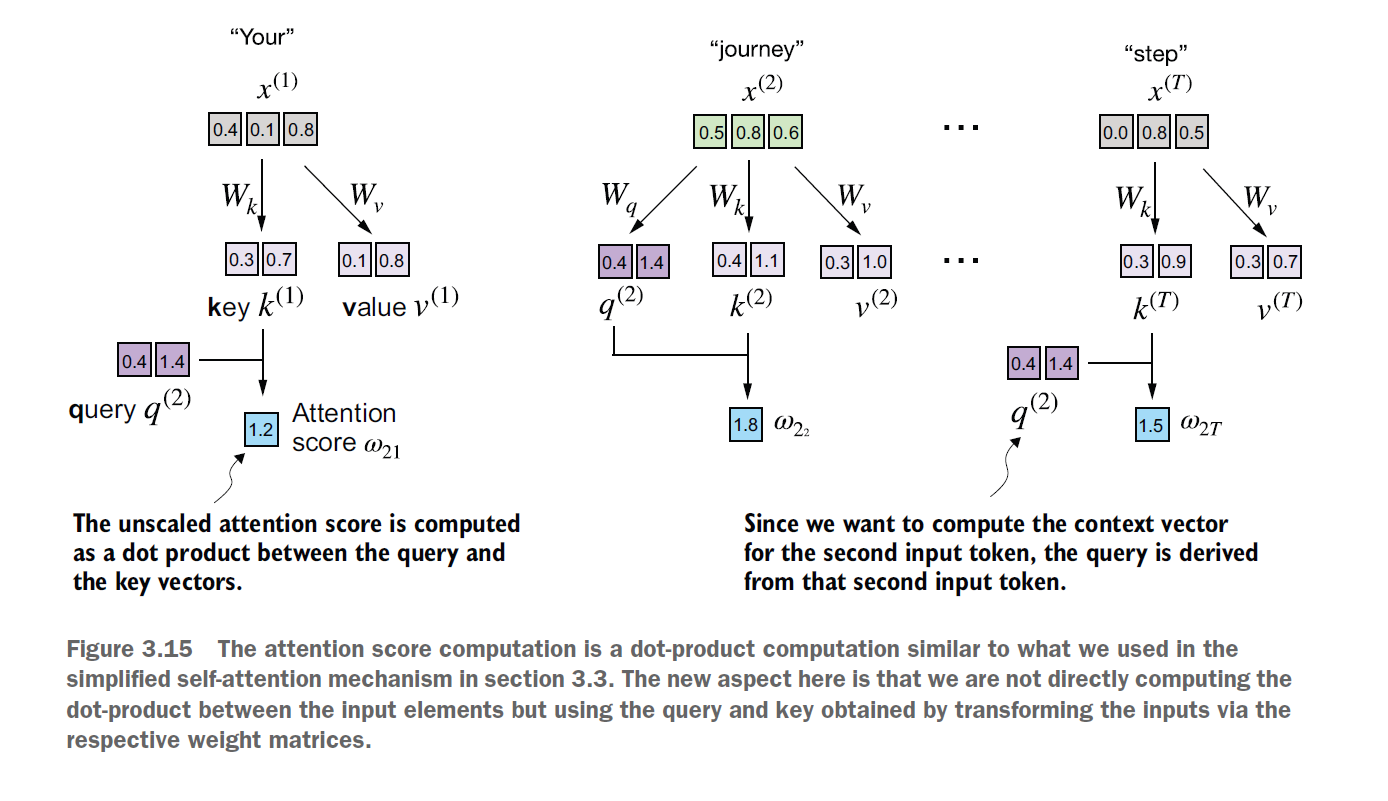

computing attention score for word 2

In [ ]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22) # Check value with the one in the figure

tensor(1.8524)


Computing all attention scores

In [ ]:
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


Computing attention weights

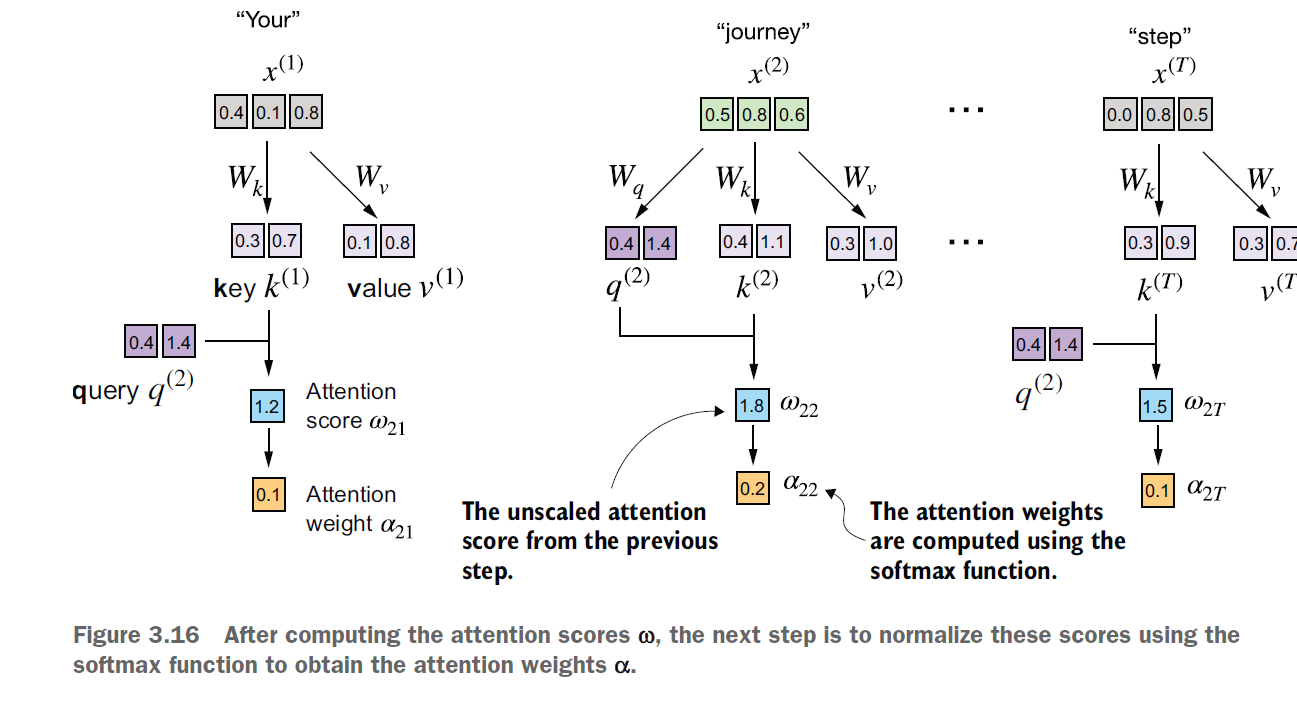

We compute the attention weights by scaling the attention scores and
using the softmax function. However, now we scale the attention scores by dividing them by the square root of the embedding dimension of the keys

The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them.

The scaling by the square root of the embedding dimension is the reason why this
self-attention mechanism is also called scaled-dot product attention

In [ ]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k ** 0.5, dim = -1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


Computing context vectors

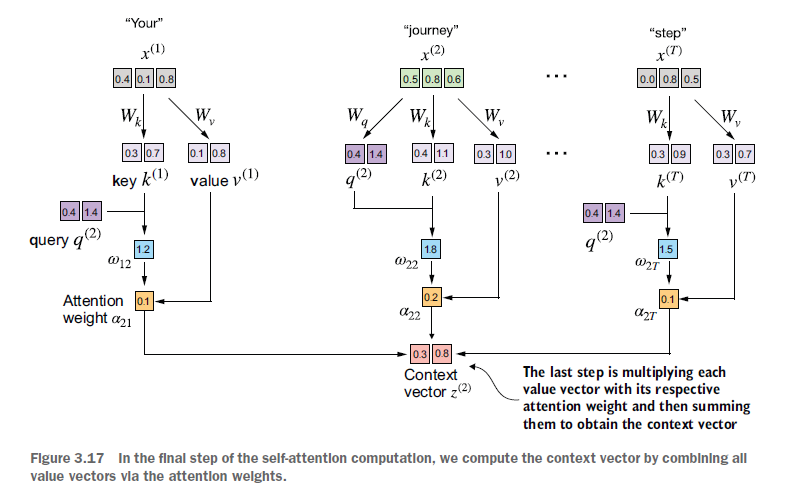

In [ ]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


we’ve only computed a single context vector, z(2). Next, we will generalize the
code to compute all context vectors in the input sequence, z(1) to z(T).

## 3.4.2 Implementing a compact self-attention Python class

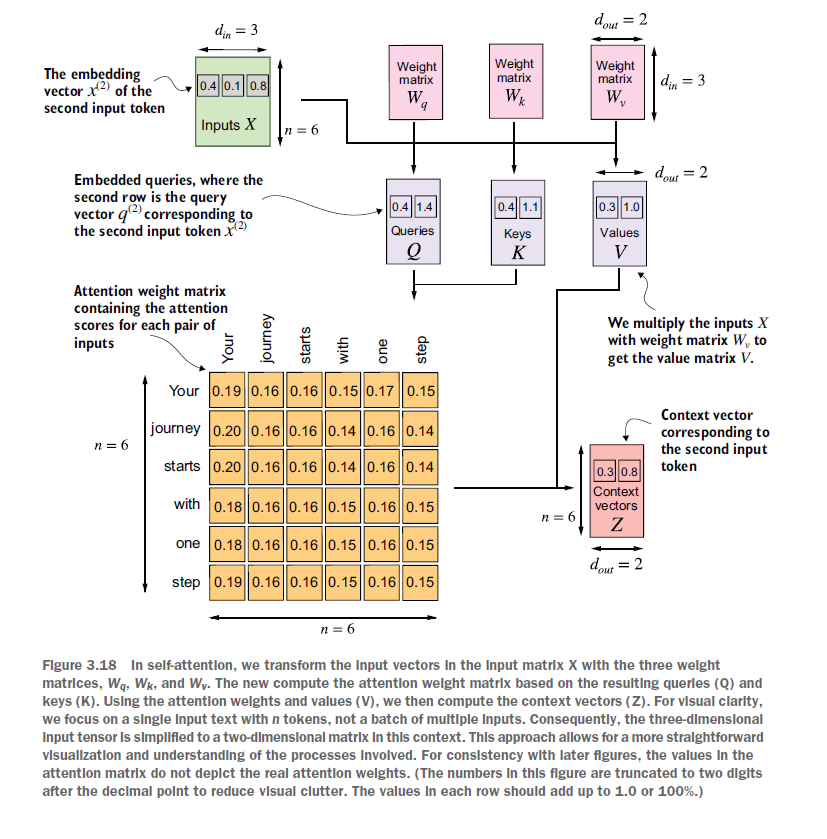

Impementing everything learned above  in a class

In [ ]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(d_in, d_out))
    self.W_key = nn.Parameter(torch.rand(d_in, d_out))
    self.W_value = nn.Parameter(torch.rand(d_in, d_out))

  def forward(self, X):
    keys = X @ self.W_key
    queries  = X @ self.W_query
    values  = X @ self.W_value
    attn_scores = queries @ keys.T # Omega
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)
    context_vec = attn_weights @ values
    return context_vec

Using the above class

Note: the `tensor[1]` is the same as the context vector that were calculated above

In [ ]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in=d_in, d_out = d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


Improving the self attention using `nn.Linear` layers. These effectively perform matrix multipliaction when the bias units are disabled. It also has an optimized weight initialization scheme.

In [ ]:
class SelfAttention_v2(nn.Module):
  def __init__(self, d_in, d_out, qkv_bias = False):
    super().__init__()
    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)

  def forward(self, x):
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)
    attn_scores = queries @ keys.T # Omega
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)
    context_vec = attn_weights @ values
    return context_vec

Using the improved self attention function

In [ ]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


The 2 versions give different outputs becasue they use different initial weights for the weight matrices since `nn.Linear` uses a different weighting scheme

# 3.5 Hiding Future words with causal attention

For most tasks we only want the model to have information on the previous tokens when predicting the next token.

Causal attention, also known as masked attention, is a specialized form of selfattention. It restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores.

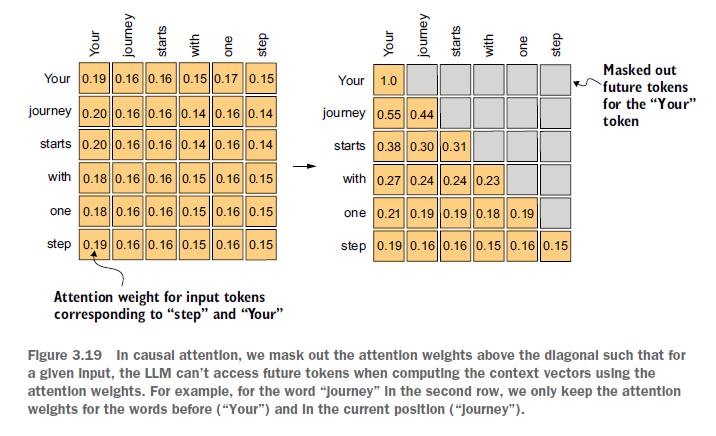

Calculating attention weights

In [ ]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Using PyTorch's `tril` function to create a mask where the values above the diagonal are zero.

In [ ]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(6, 6))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Zeroing out the attention weights

In [ ]:
masked_simple = attn_weights * mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


Renormalizing along each row
- Divide each element in each row by the sum in each row.

After masking and renormalization, the distribution of attention
weights is as if it was calculated only among the unmasked positions to begin with. This ensures there’s no information leakage from future (or otherwise masked)
tokens as we intended.

In [ ]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


The softmax function converts its inputs into a probability distribution. When negative
infinity values (-∞) are present in a row, the softmax function treats them as zero
probability.

In [ ]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal = 1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


Applying softmax to these results
This normalizes the rows

In [ ]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Calculating context vectors

In [ ]:
context_vec = attn_weights @ values
print(context_vec)

tensor([[0.1855, 0.8812],
        [0.2795, 0.9361],
        [0.3133, 0.9508],
        [0.2994, 0.8595],
        [0.2702, 0.7554],
        [0.2772, 0.7618]], grad_fn=<MmBackward0>)


## 3.5.2 Masking additional attention weights with dropout

Dropout to prevent overfitting is a deep learning method.

It is only used during training

2 different types of dropout can be done
- after calculating the attention weights
- after applying the attention weights to the value vectors

Here we apply the dropout mask after computing the attention weights (The more common variant in practice)

In [ ]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #Dropout rate of 50%
example = torch.ones(6,6) # Creating a matrix of ones
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


To compensate for the missing values we scale up the rest of the values by the same factor 2.

This is crucial to maintain the overall balencce of the attetnion weights, ensuring that the average influence of the attention mechanism remains consistent during both the training and inference phases.

In [ ]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


## 3.5.3 Implementing a compact causal attention class

handling batches

In [ ]:
batch = torch.stack((inputs, inputs), dim = 0)
print(batch.shape)

torch.Size([2, 6, 3])


Implementing `CausalAttention` with dropout and causal mask components.

One of the major advantages of using `torch.register_bufffer()` here means we don't need to manually ensure that these tensors are on the same device as your model parameters. They are automatically moved to the approprite device

In [ ]:
class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length), diagonal = 1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    attn_scores = queries @ keys.transpose(1,2)
    attn_scores.masked_fill(
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**5, dim = -1)
    attn_weights = self.dropout(attn_weights)

    context_vec = attn_weights @ values
    return context_vec

Using `CausalAttention`

In [ ]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("Context_vecs.shape:", context_vecs.shape)

Context_vecs.shape: torch.Size([2, 6, 2])


# 3.6 Extending single-head attention to multi-head attention

**Multi-head attention** divides the attention mechanism into multiple independent **heads**.  

- **Single-head attention**: One set of attention weights processes input sequentially.  
- **Multi-head attention**: Stacks multiple causal attention modules, allowing the model to focus on different aspects of the input simultaneously.  
- The transition from single to multi-head attention improves performance and efficiency.  

Using multiple instances of the self-attention
mechanism can be computationally intensive, but it’s crucial for the kind of complex
pattern recognition that models like transformer-based LLMs are known for.

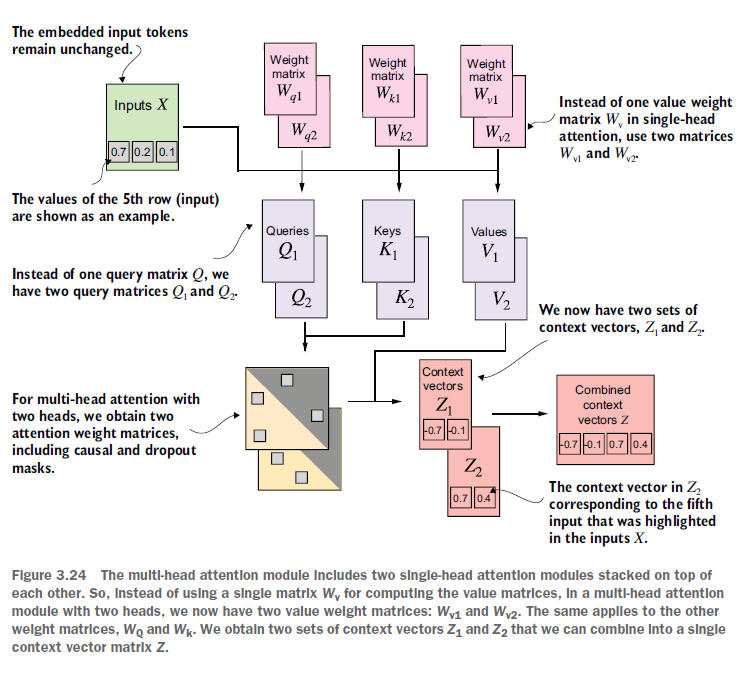

## 3.6.1 Stacking multiple single-head attention layers

Wrapper class to implement multi-head attention

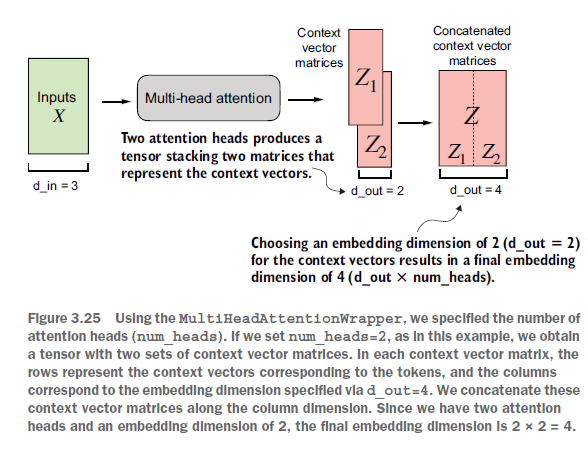

In [ ]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    self.heads = nn.ModuleList(
        [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)]
    )

  def forward(self, x):
    return torch.cat([head(x) for head in self.heads], dim = -1)

Using multiheaded attention

In [ ]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3,2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads = 2)
context_vecs = mha(batch)

print("Context vectors shape:", context_vecs.shape)
print(context_vecs)

Context vectors shape: torch.Size([2, 6, 4])
tensor([[[-0.5281, -0.1061,  0.5066,  0.3427],
         [-0.5281, -0.1062,  0.5066,  0.3427],
         [-0.5281, -0.1062,  0.5066,  0.3427],
         [-0.5279, -0.1062,  0.5065,  0.3425],
         [-0.5280, -0.1062,  0.5065,  0.3424],
         [-0.5280, -0.1063,  0.5065,  0.3426]],

        [[-0.5281, -0.1061,  0.5066,  0.3427],
         [-0.5281, -0.1062,  0.5066,  0.3427],
         [-0.5281, -0.1062,  0.5066,  0.3427],
         [-0.5279, -0.1062,  0.5065,  0.3425],
         [-0.5280, -0.1062,  0.5065,  0.3424],
         [-0.5280, -0.1063,  0.5065,  0.3426]]], grad_fn=<CatBackward0>)


The first dimension of the resulting `context_vecs` tensor is 2 since we have two input texts (the input texts are duplicated, which is why the context vectors are exactly the same for those). The second dimension refers to the 6 tokens in each input. The third dimension refers to the four-dimensional embedding of each token.

This implementation can be improved by using computing the heads in paralell

## 3.6.2 Implementing multi-head-attention with weight splits

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    assert(d_out % num_heads == 0), "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal = 1))

  def forward(self,x):
    b, num_tokens, d_in = x.shape

    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1,2)
    queries = queries.transpose(1,2)
    values = values.transpose(1,2)

    attn_scores = queries @ keys.transpose(2,3)

    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    attn_scores.masked_fill_(mask_bool, -torch.inf)

    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)

    context_vec = (attn_weights @ values).transpose(1,2).contiguous().view(b, num_tokens, self.d_out)
    context_vec = self.out_proj(context_vec)

    return context_vec

Showing the batched matrix multiplication

In [ ]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                    [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

In [ ]:
print(a @ a.transpose(2,3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


more compact way to compute the matrix multiplication for each head separately:

In [ ]:
first_head = a[0,0,:,:]
first_res = first_head @ first_head.T
print("First head: \n", first_res)

second_head = a[0,1,:,:]
second_res = second_head@second_head.T
print("Second Head: \n", second_res)

First head: 
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])
Second Head: 
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


Using MultiHeadAttention

In [ ]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads  = 2)
context_vecs = mha(batch)
print(context_vecs)
print("Context vectors shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
Context vectors shape: torch.Size([2, 6, 2])
